In [1]:
import os
import pickle
import numpy as np
import scipy.interpolate as spi
import matplotlib.pyplot as plt
%matplotlib inline

import flayer
import particle_evolution
import feo_thermodynamics as feot
import multiprocessing
import bulk_case_runner
import earth_model

In [2]:
filename = 'misfit_func_plot.npz'
npoints = 160
dtmin_1 = -40.0
dtmin_2 = -40.0
dtmax_1 = 40.0
dtmax_2 = 40.0

params = {
'f_layer_thickness' : 200000,
'delta_t_icb' : 0.0,
'xfe_outer_core' : 0.95,
'xfe_icb' : 0.95,
'growth_prefactor' : 150.0,
'i0' : 1.0e-10,
'surf_energy' : 1.08e-2,
'wetting_angle' : 180.0,
'number_of_analysis_points' : 5,
'r_icb' : 1221500,
'r_cmb' : 3480000,
'gruneisen_parameter' : 1.5,
'chemical_diffusivity' : 1.0e-9,
'kinematic_viscosity' : 1.0e-6,
'thermal_conductivity' : 100.0}

## Generate or load data

If we have a file `misfit_func_plot.npz` just load from that, otherwise generate points (over a few hrs)
and save too.

In [3]:
if os.path.exists(filename):

    print("Loading data!")
    data = np.load(filename)
    misfits = data['misfits']
    dtarr_1 = data['dt_1']
    dtarr_2 = data['dt_2']
    # Should check if misfits allign

else:
    print("Calculating data (this may take some time!")

    tfunc, tafunc, xfunc, pfunc, gfunc = flayer.setup_flayer_functions(**params)
    
    # Discretisation points
    r_flayer_top = params['r_icb'] + params['f_layer_thickness']  
    nucleation_radii = np.linspace(params['r_icb'], r_flayer_top, params['number_of_analysis_points'])
    analysis_radii = np.linspace(params['r_icb'], r_flayer_top, params['number_of_analysis_points'])

    dtarr_1 = np.linspace(dtmin_1, dtmax_1, npoints)
    dtarr_2 = np.linspace(dtmin_2, dtmax_2, npoints)
    misfits = np.empty((npoints, npoints))

    for i, d_t1 in enumerate(dtarr_1):
        print('.', end='')
        for j, d_t2 in enumerate(dtarr_2):
            input_t_points = tfunc(analysis_radii)
            input_t_points[1] = input_t_points[1] + d_t1
            input_t_points[2] = input_t_points[2] + d_t2
    
            misfits[i,j] = flayer.evaluate_flayer_wrapper_func(input_t_points, xfunc, pfunc, gfunc, 0.0, 1.0E12,
                    params['growth_prefactor'], params['chemical_diffusivity'], 
                    params['thermal_conductivity'], params['kinematic_viscosity'], 
                    params['i0'], params['surf_energy'], params['wetting_angle'],
                    None,
                    nucleation_radii, analysis_radii, params['r_icb'], 
                    r_flayer_top)
        
    # Save data
    np.savez(filename, misfits=misfits, dt_1=dtarr_1, dt_2=dtarr_2)

    
# Find best point
best_point = np.where(misfits == np.amin(misfits))
dt_1_optim = dtarr_1[best_point[0]][0]
dt_2_optim = dtarr_2[best_point[1]][0]
optim_misfit = np.amin(misfits)
print(f"Global optimim at dt_1 = {dt_1_optim} K, dt_2 = {dt_2_optim} K, value = {optim_misfit} K")


Loading data!
Global optimim at dt_1 = 17.358490566037737 K, dt_2 = 17.358490566037737 K, value = 4.629587955447544 K


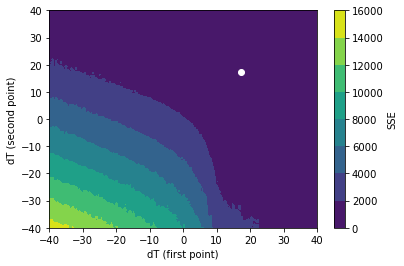

In [4]:
fig, ax = plt.subplots()
h = ax.contourf(dtarr_1, dtarr_2, misfits)
ax.plot(dt_1_optim, dt_2_optim, 'ow')
cbar = plt.colorbar(h)
cbar.set_label('SSE')
ax.set_xlabel('dT (first point)')
ax.set_ylabel('dT (second point)')
plt.show()

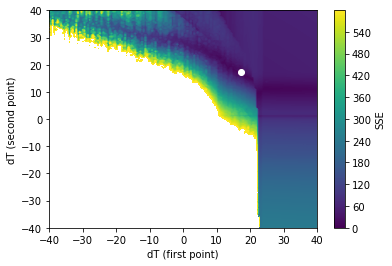

In [5]:
fig, ax = plt.subplots()
h = ax.contourf(dtarr_1, dtarr_2, misfits, levels=np.arange(600))
ax.plot(dt_1_optim, dt_2_optim, 'ow')
cbar = plt.colorbar(h)
cbar.set_label('SSE')
ax.set_xlabel('dT (first point)')
ax.set_ylabel('dT (second point)')
plt.show()

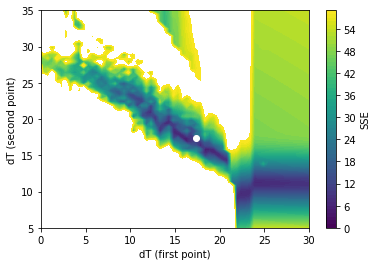

In [6]:
fig, ax = plt.subplots()
h = ax.contourf(dtarr_1, dtarr_2, misfits, levels=np.arange(60))
ax.plot(dt_1_optim, dt_2_optim, 'ow')
ax.set_xlim(0, 30)
ax.set_ylim(5, 35)
cbar = plt.colorbar(h)
cbar.set_label('SSE')
ax.set_xlabel('dT (first point)')
ax.set_ylabel('dT (second point)')
plt.show()